In [1]:
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import os
# import cv2
import random
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

# Audio processing
import librosa
import librosa.display
import audiomentations

from sklearn.preprocessing import StandardScaler, LabelEncoder

In [2]:
emotions_tras = {1:1, 2:4, 3:5, 4:0, 5:3, 6:2, 7:6}
emotions = {0:'angry', 1:'calm', 2:'disgust', 3:'fear', 4:'happy', 5:'sad', 6:'surprise'}
# emotions = {0:'neutral', 1:'calm', 2:'happy', 3:'sad', 4:'angry', 5:'fear', 6:'disgust', 7:'surprise'}

# Paths
dataset_video_path = "Datasets/RAVDESS_frames_face_BW/"
dataset_audio_path = "Datasets/RAVDESS_audio/"
models_video_path = "Models/Video Stream/"
models_audio_path = "Models/Audio Stream/"

height_orig = 224
width_orig = 224
height_targ = 112
width_targ = 112

num_classes = len(emotions)

# test_actors = ['23', '24']
test_actors = ['21', '22', '23', '24']

## Data preparation

### Video

In [3]:
filenames_test = [] # test

for dirpath, dirnames, fn in os.walk(dataset_video_path):
    dirnames.sort()
    if fn != []:
        class_temp = int(fn[0].split('-')[2]) - 1
        if class_temp != 0:                                                     # exclude 'neutral' label
            if any(act in dirpath for act in test_actors):                      # select only train actors
                path = [os.path.join(dirpath, elem) for elem in fn]
                label = [emotions_tras[class_temp]] * len(fn)                   # emotion trasposition
                filenames_test.append(list(zip(path, label)))
num_videos = len(filenames_test)
num_videos

448

In [4]:
def sampling(list, num_frames_desired):
    tot = []
    for elem in list:
        sampled_list = random.sample(elem, num_frames_desired)
        tot += sampled_list
    return(tot)

def parse_image(filename):
    
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.convert_image_dtype(image, dtype=tf.float16)
    image = tf.image.resize_with_crop_or_pad(image, height_orig, width_orig)
    image = tf.image.resize(image, [height_targ, width_targ])
    print('shape frames:', image.shape)
    return image

def configure_for_performance(ds, batch_size):
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

def load_dataset(filenames, frames_per_vid):
    print("frames per video:", frames_per_vid) 
    batch_size = frames_per_vid

    filenames_sampled = sampling(filenames, frames_per_vid)

    zipped = [list(t) for t in zip(*filenames_sampled)]

    names = zipped[0]
    labels = zipped[1]

    names = tf.data.Dataset.from_tensor_slices(names)
    images = names.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    labels = [elem for elem in labels]
    labels = tf.data.Dataset.from_tensor_slices(labels)

    ds = tf.data.Dataset.zip((images, labels))
    ds = configure_for_performance(ds, batch_size)

    frame_number = len(filenames_sampled)
    step_per_epoch = frame_number // batch_size
    print('frames number:', frame_number, '\nbatch size:', batch_size, '\nbatch number:', step_per_epoch)
    return ds, step_per_epoch

In [5]:
frames_per_vid = min([len(elem) for elem in filenames_test])     # number of frames per clip in order to have balanced classes
test_ds, step_per_epoch_test = load_dataset(filenames_test, frames_per_vid)

frames per video: 24
shape frames: (112, 112, 1)
frames number: 10752 
batch size: 24 
batch number: 448


In [6]:
train_x, train_y = tf.compat.v1.data.make_one_shot_iterator(test_ds).get_next()
train_y

<tf.Tensor: shape=(24,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])>

(112, 112, 1)
calm


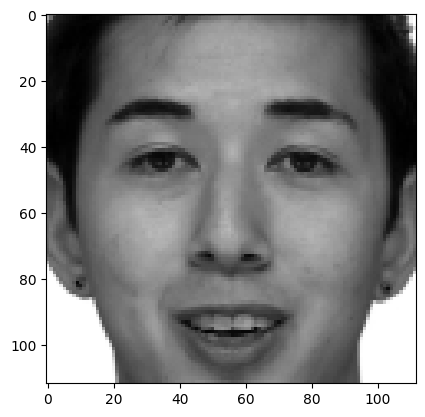

In [7]:
b = test_ds.unbatch().take(1)

for elem in b:
    print(elem[0].shape)
    print(emotions[int(elem[1])])
plt.imshow(elem[0], cmap='gray')

### Audio

In [8]:
X_test = np.load(dataset_audio_path + 'X_test.npy')
y_test = np.load(dataset_audio_path + 'y_test.npy')

## Load best models

### Video

In [9]:
models_list = os.listdir(models_video_path)

acc = [float(model.split('[')[1].split(']')[0]) for model in models_list]
idx = acc.index(max(acc))                                                       # index of best model

model_video = keras.models.load_model(models_video_path + models_list[idx])
# model_video.summary()

F:\Programming\Anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
F:\Programming\Anaconda\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


### Audio

In [10]:
models_list = os.listdir(models_audio_path)
model_audio = keras.models.load_model(models_audio_path + models_list[0])
# model_audio.summary()

## Predictions

### Video

#### Evaluate single frame

In [11]:
loss_single_frame, acc_single_frame = model_video.evaluate(test_ds, steps=step_per_epoch_test)
print('accuratezza single frame:', round(acc_single_frame, 4))

ValueError: Expected all entries in the `metrics` list to be metric objects. Received instead:
metrics=[[<MeanMetricWrapper name=sparse_categorical_accuracy>]]

In [12]:
pred_frames = model_video.predict(test_ds, steps=step_per_epoch_test)
ground_frames = [elem[0][1]  for elem in filenames_test]
ground_frames = np.repeat(ground_frames, frames_per_vid)

448/448 ━━━━━━━━━━━━━━━━━━━━ 96s 214ms/step


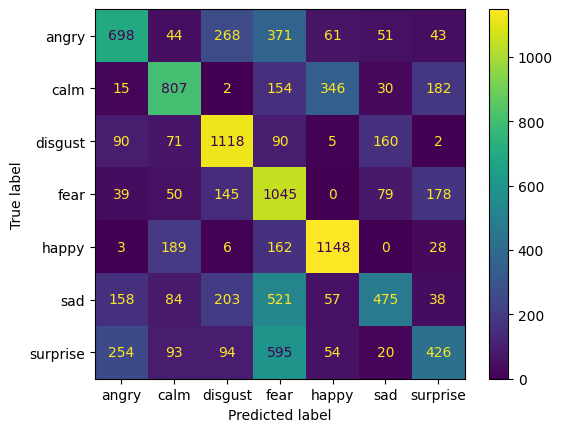

In [13]:
cm_frames = confusion_matrix(ground_frames, pred_frames.argmax(axis=1))
disp = ConfusionMatrixDisplay(cm_frames, display_labels=list(emotions.values()))
disp.plot()

In [14]:
recall_frames = np.diag(cm_frames) / np.sum(cm_frames, axis = 1)
precision_frames = np.diag(cm_frames) / np.sum(cm_frames, axis = 0)

stats_frames = pd.DataFrame({'Recall': recall_frames, 'Precision': precision_frames}, index=emotions.values())
round(stats_frames, 2)

,Recall,Precision
angry,0.45,0.56
calm,0.53,0.60
disgust,0.73,0.61
fear,0.68,0.36
happy,0.75,0.69
sad,0.31,0.58
surprise,0.28,0.47


#### Evaluate full video

In [15]:
pred_video_frames = model_video.predict(test_ds, steps=step_per_epoch_test)

448/448 ━━━━━━━━━━━━━━━━━━━━ 60s 133ms/step


In [16]:
example_id = 0
example = np.array_split(pred_video_frames, num_videos)[example_id]

print('ground truth:\t', filenames_test[example_id][0][1])

# print('predicted:\t', np.median(o, axis=0).argmax())
# print('predicted:\t', np.sum(o, axis=0).argmax())
print('predicted:\t', np.mean(example, axis=0).argmax())
np.sum(example, axis=0)

ground truth:	 1
predicted:	 1


array([5.7524897e-02, 2.0718678e+01, 1.1020304e-03, 3.3343282e-01,
       5.0872630e-01, 4.7054797e-01, 1.9099916e+00], dtype=float32)

In [17]:
pred_video_list = np.array_split(pred_video_frames, num_videos)

ground_video = []
pred_video = []

i = 0
for count, video in enumerate(pred_video_list):
    pred_video.append(np.mean(video, axis=0))
    # predic.append(np.average(video, axis=0, weights=np.max(video, axis=1)).argmax()) # weighted mean on highest prediction value
    ground_video.append(filenames_test[count][0][1])
    
    if np.array(pred_video[count]).argmax() == ground_video[count]:
        i += 1

pred_video = np.array(pred_video)
print('accuracy full video:\t', round(i/len(pred_video_list), 4))
print('Num videos:\t\t', count+1)

accuracy full video:	 0.625
Num videos:		 448


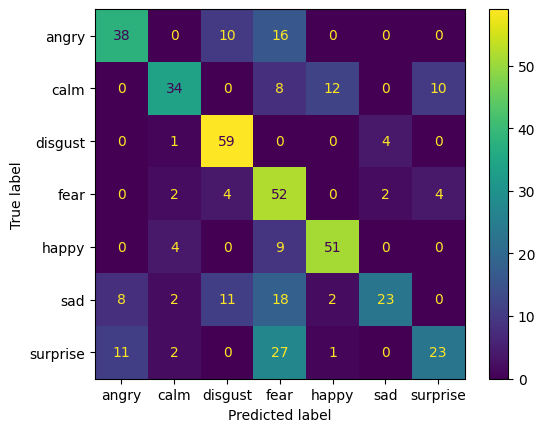

In [18]:
cm_video = confusion_matrix(ground_video, pred_video.argmax(axis=1))
disp = ConfusionMatrixDisplay(cm_video, display_labels=list(emotions.values()))
disp.plot()

In [19]:
recall_video = np.diag(cm_video) / np.sum(cm_video, axis = 1)
precision_video = np.diag(cm_video) / np.sum(cm_video, axis = 0)

stats_video = pd.DataFrame({'Recall': recall_video, 'Precision': precision_video}, index=emotions.values())
round(stats_video, 2)

,Recall,Precision
angry,0.59,0.67
calm,0.53,0.76
disgust,0.92,0.70
fear,0.81,0.40
happy,0.80,0.77
sad,0.36,0.79
surprise,0.36,0.62


### Audio

In [20]:
pred_audio = model_audio.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 612ms/step


In [21]:
ground_audio = np.argmax(y_test, axis = 1)

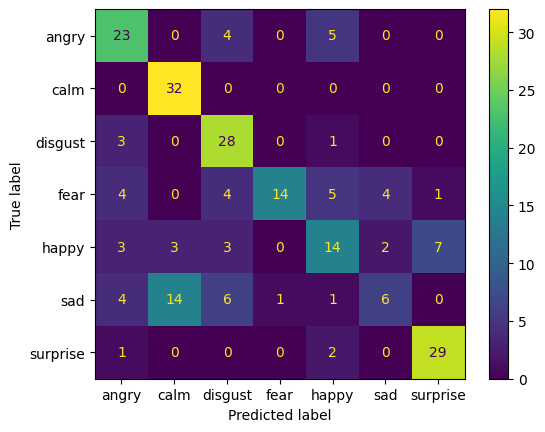

In [22]:
cm_audio = confusion_matrix(ground_audio, pred_audio.argmax(axis=1))
disp = ConfusionMatrixDisplay(cm_audio, display_labels=list(emotions.values()))
disp.plot()

### Global

In [23]:
audio_f1 = [0.52, 0.65, 0.83, 0.87, 0.48, 0.40, 0.93] # np.ones((1,7)) - 
video_f1 = [0.39, 0.83, 0.69, 0.53, 0.72, 0.44, 0.61]

audio_prec = [0.58, 0.72, 0.72, 0.52, 0.43, 0.45, 0.72]
video_prec = [0.27, 0.58, 0.65, 0.60, 0.90, 0.43, 0.75]

audio_weights = audio_f1
video_weights = video_f1

In [27]:
# Ensure matching dimensions for predictions
if pred_video.shape[0] != pred_audio.shape[0]:
    pred_video = pred_video[:min(len(pred_video), len(pred_audio))]
    pred_audio = pred_audio[:min(len(pred_video), len(pred_audio))]

# Broadcast weights
audio_weights = np.array(audio_weights).reshape(1, -1)
video_weights = np.array(video_weights).reshape(1, -1)

# Compute weighted mean
pred_global = pred_video * video_weights + pred_audio * audio_weights
ground_global = ground_audio[:pred_global.shape[0]]  # Ensure ground truth matches the prediction dimensions


In [28]:
pred_global = pred_video + pred_audio # mean
ground_global = ground_audio

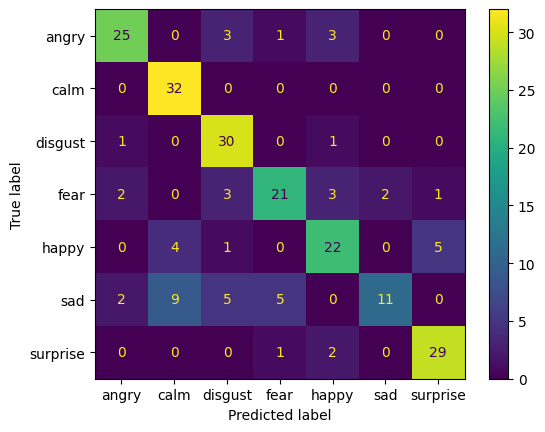

In [29]:
cm_global = confusion_matrix(ground_global, pred_global.argmax(axis=1))
disp = ConfusionMatrixDisplay(cm_global, display_labels=list(emotions.values()))
disp.plot()
plt.savefig('Plots/VideoCM_FullClip.png', dpi=300)

In [30]:
1 - np.count_nonzero(ground_global-pred_global.argmax(axis=1)) / len(ground_global)

0.7589285714285714